# Lab Assignment Four: Multi-Layer Perceptron 

In this lab, we will compare the performance of multi-layer perceptrons programmed via our own various implementations.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela.

2) Yihan Zhou

3) Sofiya Chaku

4) Naim Barnett

## Dataset Description (as per Kaggle)

The data here are taken from the DP03 and DP05 tables of the 2015 American Community Survey 5-year estimates. The full datasets and much more can be found at the American Factfinder website.

The classification task we will be performing is to predict, for each county, what the child poverty rate will be.

## Load, Split, and Balance

In [76]:
'''Importing all the required libraries throughout the lab'''
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import os 
import warnings
import re
warnings.simplefilter('ignore', DeprecationWarning)
from sklearn.model_selection import train_test_split
import math
from scipy.special import expit
import sys
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


In [77]:
"""Loading the data into memory and saving it to a pandas dataframe"""
data = pd.read_csv("Data/acs2015_county_data.csv", low_memory=False)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusId         3220 non-null   int64  
 1   State            3220 non-null   object 
 2   County           3220 non-null   object 
 3   TotalPop         3220 non-null   int64  
 4   Men              3220 non-null   int64  
 5   Women            3220 non-null   int64  
 6   Hispanic         3220 non-null   float64
 7   White            3220 non-null   float64
 8   Black            3220 non-null   float64
 9   Native           3220 non-null   float64
 10  Asian            3220 non-null   float64
 11  Pacific          3220 non-null   float64
 12  Citizen          3220 non-null   int64  
 13  Income           3219 non-null   float64
 14  IncomeErr        3219 non-null   float64
 15  IncomePerCap     3220 non-null   int64  
 16  IncomePerCapErr  3220 non-null   int64  
 17  Poverty       

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [78]:
"""Removing observations that have missing data"""
#Replace all blank strings will null to be dropped
data.replace('', np.nan, inplace=True)
#Remove all rows with null values
data.dropna(inplace=True)
#Find duplicate instances
duplicates = data[data.duplicated()]
#Remove all duplicates
data = data.drop_duplicates()
#After removal 
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3218 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusId         3218 non-null   int64  
 1   State            3218 non-null   object 
 2   County           3218 non-null   object 
 3   TotalPop         3218 non-null   int64  
 4   Men              3218 non-null   int64  
 5   Women            3218 non-null   int64  
 6   Hispanic         3218 non-null   float64
 7   White            3218 non-null   float64
 8   Black            3218 non-null   float64
 9   Native           3218 non-null   float64
 10  Asian            3218 non-null   float64
 11  Pacific          3218 non-null   float64
 12  Citizen          3218 non-null   int64  
 13  Income           3218 non-null   float64
 14  IncomeErr        3218 non-null   float64
 15  IncomePerCap     3218 non-null   int64  
 16  IncomePerCapErr  3218 non-null   int64  
 17  Poverty       

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,...,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,...,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,...,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


In [79]:
"""Incoding string data as integers"""
#Incoding states' names
print("The number of observations for each state before incoding was:")
print(data['State'].value_counts())
states_names = data["State"].unique()
states_id = np.arange(states_names.size)
data.replace(states_names,states_id, inplace=True)
data.replace(data["State"].unique(),states_id, inplace=True)
print("The number of observations for each state after incoding becomes:")
print(data['State'].value_counts())

#Incoding county names
print("The number of observations for each County before incoding was:")
print(data['County'].value_counts())
county_names = data["County"].unique()
county_id = np.arange(county_names.size)
data.replace(county_names,county_id, inplace=True)
print("The number of observations for each County after incoding becomes:")
print(data['County'].value_counts())

data.info()

The number of observations for each state before incoding was:
Texas                   253
Georgia                 159
Virginia                133
Kentucky                120
Missouri                115
Kansas                  105
Illinois                102
North Carolina          100
Iowa                     99
Tennessee                95
Nebraska                 93
Indiana                  92
Ohio                     88
Minnesota                87
Michigan                 83
Mississippi              82
Puerto Rico              78
Oklahoma                 77
Arkansas                 75
Wisconsin                72
Pennsylvania             67
Alabama                  67
Florida                  67
South Dakota             66
Louisiana                64
Colorado                 64
New York                 62
California               58
Montana                  56
West Virginia            55
North Dakota             53
South Carolina           46
Idaho                    44
Washington   

In [80]:
data.replace(data["State"].unique(),states_id, inplace=True)
print(data["State"].value_counts())

43    253
10    159
46    133
17    120
25    115
16    105
13    102
33    100
15     99
42     95
27     93
14     92
35     88
23     87
22     83
24     82
51     78
36     77
3      75
49     72
38     67
0      67
9      67
41     66
18     64
5      64
32     62
4      58
26     56
48     55
34     53
40     46
12     44
47     39
37     36
31     33
1      29
44     29
20     24
50     23
30     21
28     17
19     16
2      15
21     14
45     14
29     10
6       8
39      5
11      4
7       3
8       1
Name: State, dtype: int64


In [81]:
"""Split the dataset into 80% for training and 20% for testing."""
# Creating our data matrix (X) and our target variable (y) that we will work on from the dataframe we have
X = data.copy().drop(["ChildPoverty"],axis=1).to_numpy()
#y = data[['Credit_Score']].to_numpy()
y = data.ChildPoverty.to_numpy()
print("The shape of the data matrix: " + str(X.shape))
print("The shape of the target variable: " + str(y.shape))
# Dividing the data into training and testing data using an 80% training and 20% testing split.
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=0)
print("The training matrix and target shapes: " + str(X_train.shape)+ ' & ' + str(y_train.shape))
print("The testing matrix and target shapes: " + str(X_test.shape)+ ' & ' + str(y_test.shape))

The shape of the data matrix: (3218, 36)
The shape of the target variable: (3218,)
The training matrix and target shapes: (2574, 36) & (2574,)
The testing matrix and target shapes: (644, 36) & (644,)


We choose to quantize threshold for the "ChildPoverty" variable that equally divide the data into four classes. We do this balancing using the entire dataset altogether, and then also apply it to training and testing to have the same evaluation criteria and division, because otherwise, the thresholds for the training and the testing sets will be different and it will be meaningless to predict the target on the test set using a model that was trained for the thresholds of the training set.

In [82]:
"""Balancing the dataset by finding quantization thresholds for the Child Poverty variable"""
#a function that acts on the dataset, and finds the three threshold points that define the four quarters of the variable
def get_threshold_points():
    i = 0;
    threshold_points = []
    while True:
        if int(data[data["ChildPoverty"] < i]["ChildPoverty"].size) >= math.floor(int(data["ChildPoverty"].size)/4): 
            threshold_points.append(i)
            while True:
                if int(data[data["ChildPoverty"] < i]["ChildPoverty"].size) >= math.floor(int(data["ChildPoverty"].size)/2): 
                    threshold_points.append(i)
                    while True:
                        if int(data[data["ChildPoverty"] < i]["ChildPoverty"].size) >= math.floor(int(data["ChildPoverty"].size)*3/4): 
                            threshold_points.append(i)
                            break
                        else: i += 0.001
                    break
                else: i += 0.001
            break
        else: i += 0.001

    return threshold_points

threshold_pts = get_threshold_points()

In [83]:
print(threshold_pts)
first_quarter = data[data["ChildPoverty"] < threshold_pts[0]]
other_than_first = data[data["ChildPoverty"] > threshold_pts[0]]
second_quarter = other_than_first[other_than_first["ChildPoverty"] < threshold_pts[1]]
other_than_second = data[data["ChildPoverty"] > threshold_pts[1]]
third_quarter = other_than_second[other_than_second["ChildPoverty"] < threshold_pts[2]]
fourth_quarter = data[data["ChildPoverty"] > threshold_pts[2]]
print("The number of instances in the first quarter:",int(first_quarter["ChildPoverty"].size))
print("The number of instances in the second quarter:",int(second_quarter["ChildPoverty"].size))
print("The number of instances in the third quarter:",int(third_quarter["ChildPoverty"].size))
print("The number of instances in the fourth quarter:",int(fourth_quarter["ChildPoverty"].size))
print('''The "almost perfect" number of instances tha should be in each quarter:''',math.floor(int(data["ChildPoverty"].size)/4))
#as we can see, we can't perfectly divide them into four equal sets because on the edge, at point 16.8, we have 19 
#observations which will all belong to the first quarter, making it exceed. Since we want to have more flexibility
#and we want to be more inclined towards classifying people in the less poverty rate bracket, we will assign them
#to the first quarter, but in general, it will depend on the problem in hand.5
print("The number of observations that set on the edge of the first quarter:",int(data[data["ChildPoverty"] == 16.8]["ChildPoverty"].size))

[16.30099999999694, 22.70000000000476, 30.00000000001368]
The number of instances in the first quarter: 812
The number of instances in the second quarter: 804
The number of instances in the third quarter: 799
The number of instances in the fourth quarter: 803
The "almost perfect" number of instances tha should be in each quarter: 804
The number of observations that set on the edge of the first quarter: 19


In [84]:
#Applying the quantization to our target value "Child Poverty" in the training set
y_train[y_train < threshold_pts[0]] = 0
y_train[(y_train > threshold_pts[0]) & (y_train < threshold_pts[1])] = 1
y_train[(y_train > threshold_pts[1]) & (y_train < threshold_pts[2])] = 2
y_train[y_train > threshold_pts[2]] = 3
print(y_train)

[2. 3. 1. ... 0. 1. 2.]


In [85]:
#Applying the quantization to our target value "Child Poverty" in the testing set
y_test[y_test < threshold_pts[0]] = 0
y_test[(y_test > threshold_pts[0]) & (y_test < threshold_pts[1])] = 1
y_test[(y_test > threshold_pts[1]) & (y_test < threshold_pts[2])] = 2
y_test[y_test > threshold_pts[2]] = 3
print(y_test)

[3. 0. 3. 2. 2. 1. 2. 2. 1. 0. 0. 3. 1. 1. 0. 0. 1. 1. 3. 3. 2. 1. 1. 1.
 0. 2. 3. 0. 3. 2. 3. 3. 0. 2. 2. 1. 1. 2. 2. 1. 3. 0. 2. 3. 2. 2. 0. 3.
 3. 2. 0. 0. 3. 2. 2. 1. 3. 2. 1. 1. 1. 2. 2. 3. 1. 2. 3. 3. 0. 1. 1. 3.
 1. 1. 3. 3. 1. 0. 1. 2. 0. 0. 1. 3. 3. 3. 2. 1. 3. 2. 1. 0. 3. 3. 0. 0.
 1. 3. 3. 0. 2. 1. 2. 0. 1. 0. 0. 2. 2. 0. 3. 1. 0. 3. 3. 0. 3. 2. 0. 3.
 0. 3. 0. 0. 1. 1. 1. 1. 0. 1. 2. 1. 3. 2. 1. 1. 0. 3. 3. 2. 1. 2. 0. 0.
 1. 3. 3. 0. 2. 0. 2. 0. 3. 0. 1. 1. 1. 1. 3. 2. 3. 0. 1. 1. 0. 3. 2. 1.
 0. 3. 3. 3. 0. 1. 2. 1. 2. 2. 3. 3. 3. 0. 2. 3. 2. 0. 1. 2. 1. 3. 3. 3.
 1. 0. 1. 0. 1. 0. 3. 1. 1. 3. 2. 2. 0. 2. 3. 1. 2. 1. 0. 1. 3. 2. 3. 1.
 1. 3. 3. 2. 3. 1. 1. 0. 2. 1. 3. 0. 1. 3. 1. 3. 2. 2. 0. 3. 3. 2. 2. 3.
 2. 3. 1. 2. 3. 0. 3. 1. 2. 0. 1. 3. 1. 1. 1. 0. 1. 1. 0. 3. 0. 3. 3. 0.
 1. 1. 3. 3. 0. 2. 2. 0. 0. 0. 3. 3. 1. 2. 2. 2. 3. 0. 3. 2. 2. 1. 3. 2.
 0. 1. 2. 3. 0. 0. 2. 3. 3. 3. 1. 1. 1. 1. 3. 1. 3. 3. 0. 2. 1. 0. 3. 2.
 1. 1. 3. 3. 0. 3. 1. 3. 2. 1. 3. 0. 1. 3. 2. 2. 1.

## Pre-processing (2.5 points total)

We use the two layer perceptron classes from class that have: (1) vectorized computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization. We also use the ones that do Adaptive learning rate and momentum  

In [86]:
"""Using the code from the lecture"""

"""Defining the base class of the neural network"""
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [87]:
"""Deriving the class with feedforward, fit and predict"""
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
        pass
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [88]:
"""Deriving the class with Vectorized inputs and outputs and calculations"""
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2

In [89]:
"""Deriving the class with mini-batching added"""
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [90]:
"""Deriving the class with cross entropy added"""
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [91]:
"""Deriving a class with Glorot Initialization"""
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

In [92]:
"""Training on our data"""
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':200, 'eta':0.01, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

nn = TLPBetterInitial(**vals)

nn.fit(X_train, y_train, print_progress=1)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 200/200

Accuracy: 0.36024844720496896


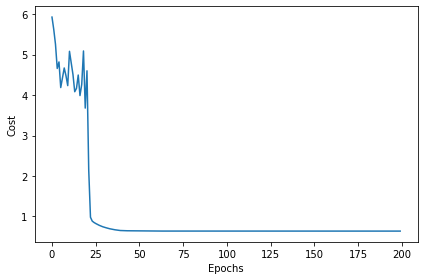

In [93]:
"""Plotting the cost function versus the number of epochs""" ##inspired by the lecture too
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Normalizing the continuous numeric feature data using standardization

Epoch: 200/200

Accuracy: 0.7484472049689441


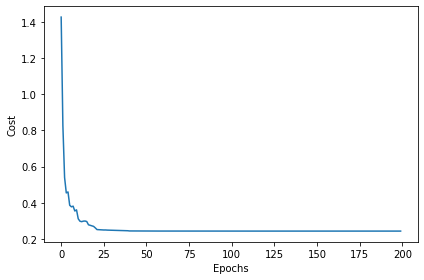

In [94]:
"""Normalizing the continuous numeric feature data using standardization"""
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

nn = TLPBetterInitial(**vals)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Epoch: 200/200

Accuracy: 0.31832298136645965


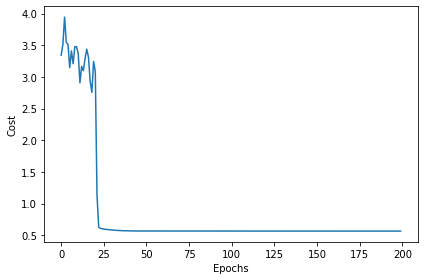

In [95]:
"""One Hot Encoding the data we have"""
#getting back the original categories for the dataframe
data["State"].replace(states_id, states_names, inplace=True)
data["County"].replace(county_id, county_names, inplace=True)
data.head()

#doing the one-hot encoding and reconstructing the data matrix
X = pd.get_dummies(data.copy())
X = X.drop(["ChildPoverty"],axis=1).to_numpy()

#Constructing the new split using the new one-hot encoded data matrix
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=0)

#Applying the quantization to our target value "Child Poverty" in the training set
y_train[y_train < threshold_pts[0]] = 0
y_train[(y_train > threshold_pts[0]) & (y_train < threshold_pts[1])] = 1
y_train[(y_train > threshold_pts[1]) & (y_train < threshold_pts[2])] = 2
y_train[y_train > threshold_pts[2]] = 3

#Applying the quantization to our target value "Child Poverty" in the testing set
y_test[y_test < threshold_pts[0]] = 0
y_test[(y_test > threshold_pts[0]) & (y_test < threshold_pts[1])] = 1
y_test[(y_test > threshold_pts[1]) & (y_test < threshold_pts[2])] = 2
y_test[y_test > threshold_pts[2]] = 3

nn = TLPBetterInitial(**vals)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Looking at the accuracy scores and the loss function graphs versus the number of epochs, it is very clear that we get the best performance when only applying the normalization to the data matrix. This should be expected because we center the feature columns at mean 0 with standard
deviation 1 so that the feature columns have the same parameters as a standard
normal distribution (zero mean and unit variance), which makes it easier to learn
the weights. However, the worst performance happened when we applied the one-hot encoding besdies the normalization. this is probably because of the very high number of features we are deadling with.

## Modeling

We know implement the three layer perceptron. We do so while keeping our minimum requirements of doing: (1) vectorized computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization. This will require many changes in each of the four classes functions, we will indicate changes whenever happened.

In [96]:
class ThreeLayerPerceptronBase(object):
    def __init__(self, n_hidden_1=30, n_hidden_2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        """Added a container for the number of units in the extra hidden layer"""
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden_1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden_1, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden_1, 1))
        
        """Initializing the weights for the new added third layer"""

        W2_num_elems = (self.n_hidden_1)*self.n_hidden_2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden_2, self.n_hidden_1) # reshape to be W
        b2 = np.zeros((self.n_hidden_2, 1))
        
        W3_num_elems = (self.n_hidden_2)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden_2)
        b3 = np.zeros((self.n_output_, 1))


        
        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        """Including the mean of the new added third layer"""
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3) #notice the new function input referring to the new layer
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> 1st hidden layer.
        W2: Weight matrix for hidden layer -> 2nd hidden layer.
        W3: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a4 : activations into layer (or output layer)
        z1-z3 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)
        V2 = A3*(1-A3)*(W3.T @ V3) # The new added third layer
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T     #the gradient of the new layer
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))     #the bias of the new layer
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C       #regularizing the weight for the new layer
        gradW3 += W3 * self.l2_C 

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [97]:
"""Deriving the class with mini-batching added"""
class ThreeLPMiniBatch(ThreeLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()
        
        
        #initializing containers of the average weight for each epoch
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):
            eta = self.eta

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            #Containers for the average weight per batch to be averaged to the average per epoch
            self.grad_w1_batch = []
            self.grad_w2_batch = []
            self.grad_w3_batch = []

            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3
                                                      )
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)
                
                #adding the mean of the gradients to their respective containers to be averaged later
                self.grad_w1_batch.append(gradW1.mean())
                self.grad_w2_batch.append(gradW2.mean())
                self.grad_w3_batch.append(gradW3.mean())

                #Updating the weights
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                
            #Converting to numpy arrrays to be able to calculate the means of the batch gradients for every epoch
            self.grad_w1_batch = np.array(self.grad_w1_batch)
            self.grad_w2_batch = np.array(self.grad_w2_batch)
            self.grad_w3_batch = np.array(self.grad_w3_batch)
            self.grad_w1_[i] =  self.grad_w1_batch.mean()
            self.grad_w2_[i] =  self.grad_w2_batch.mean()
            self.grad_w3_[i] =  self.grad_w3_batch.mean()
            
            

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
        
        #Plotting the average gradient magnitude for each epoch
        ax = plt.subplot(1,1,1)
        plt.plot(abs(self.grad_w1_[10:]), label='w1')
        plt.plot(abs(self.grad_w2_[10:]), label='w2')
        plt.plot(abs(self.grad_w3_[10:]), label='w3')
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('Epochs')
        plt.show()

        return self

In [98]:
"""Deriving the class with cross entropy added"""
class ThreeLPMiniBatchCrossEntropy(ThreeLPMiniBatch):
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    # def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
    #     """ Compute gradient step using backpropagation.
    #     """
    #     # vectorized backpropagation
    #     V3 = (A4-Y_enc) # <- this is only line that changed
    #     V2 = A3*(1-A3)*(W3.T @ V3)
    #     V1 = A2*(1-A2)*(W2.T @ V2)
        
    #     gradW3 = V3 @ A3.T
    #     gradW2 = V2 @ A2.T
    #     gradW1 = V1 @ A1.T

    #     gradb3 = np.sum(V3, axis=1).reshape((-1,1))
    #     gradb2 = np.sum(V2, axis=1).reshape((-1,1))
    #     gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
    #     # regularize weights that are not bias terms
    #     gradW1 += W1 * self.l2_C
    #     gradW2 += W2 * self.l2_C
    #     gradW3 += W3 * self.l2_C

    #     return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

In [99]:
"""Deriving a class with Glorot Initialization"""
class ThreeLPBetterInitial(ThreeLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))

        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_2))
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3

Epoch: 200/200

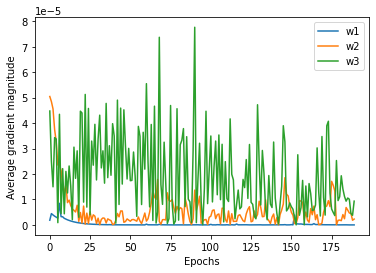

Accuracy: 0.2375776397515528


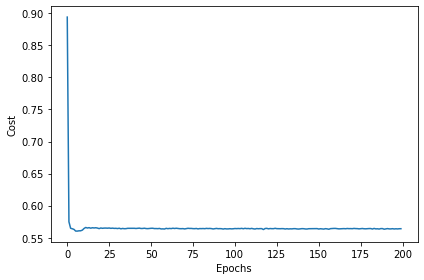

In [100]:
"""Training on our data"""
#notice the new "n_hidden_2" in the initialization to control the number of units in the hidden layer
vals_new = {'n_hidden_1':50, 'n_hidden_2':50,
         'C':1e-2, 'epochs':200, 'eta':0.01, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':int(len(X_train)/2),
         'shuffle':True,'random_state':1}

nn = ThreeLPBetterInitial(**vals_new)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

[1 points] Repeat the previous step, adding support for a fourth layer.


In [102]:
class FourLayerPerceptronBase(object):
     def __init__(self, n_hidden_1=30, n_hidden_2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        """Added a container for the number of units in the extra hidden layer"""
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden_1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden_1, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden_1, 1))
        
        """Initializing the weights for the new added third layer"""

        W2_num_elems = (self.n_hidden_1)*self.n_hidden_2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden_2, self.n_hidden_1) # reshape to be W
        b2 = np.zeros((self.n_hidden_2, 1))
        
        W3_num_elems = (self.n_hidden_2)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden_2)
        b3 = np.zeros((self.n_output_, 1))


        
        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        """Including the mean of the new added third layer"""
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3) #notice the new function input referring to the new layer
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> 1st hidden layer.
        W2: Weight matrix for hidden layer -> 2nd hidden layer.
        W3: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a4 : activations into layer (or output layer)
        z1-z3 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)
        V2 = A3*(1-A3)*(W3.T @ V3) # The new added third layer
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T     #the gradient of the new layer
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))     #the bias of the new layer
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C       #regularizing the weight for the new layer
        gradW3 += W3 * self.l2_C 

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 12)

In [ ]:
"""Deriving the class with mini-batching added"""
class FourLPMiniBatch(FourLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        # # start momentum at zero for previous updates
        # rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        # rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        # rho_W3_prev = np.zeros(self.W3.shape) # for momentum

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            # eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))
            eta = self.eta

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            self.grad_w1_batch = []
            self.grad_w2_batch = []
            self.grad_w3_batch = []

            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3
                                                      )
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)

                self.grad_w1_batch.append(gradW1.mean())
                self.grad_w2_batch.append(gradW2.mean())
                self.grad_w3_batch.append(gradW3.mean())

                # # momentum calculations
                # rho_W1, rho_W2, rho_W3 = eta * gradW1, eta * gradW2, eta * gradW3
                # self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                # self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                # self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.W3 -= self.eta * gradW3
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                # rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3
                
            self.grad_w1_batch = np.array(self.grad_w1_batch)
            self.grad_w2_batch = np.array(self.grad_w2_batch)
            self.grad_w3_batch = np.array(self.grad_w3_batch)
            self.grad_w1_[i] =  self.grad_w1_batch.mean()
            self.grad_w2_[i] =  self.grad_w2_batch.mean()
            self.grad_w3_[i] =  self.grad_w3_batch.mean()
            
            

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))

        ax = plt.subplot(1,1,1)
        plt.plot(abs(self.grad_w1_[10:]), label='w1')
        plt.plot(abs(self.grad_w2_[10:]), label='w2')
        plt.plot(abs(self.grad_w3_[10:]), label='w3')
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('Epochs')
        plt.show()

        return self

In [ ]:
"""Deriving the class with cross entropy added"""
class FourLPMiniBatchCrossEntropy(FourLPMiniBatch):
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    # def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
    #     """ Compute gradient step using backpropagation.
    #     """
    #     # vectorized backpropagation
    #     V3 = (A4-Y_enc) # <- this is only line that changed
    #     V2 = A3*(1-A3)*(W3.T @ V3)
    #     V1 = A2*(1-A2)*(W2.T @ V2)
        
    #     gradW3 = V3 @ A3.T
    #     gradW2 = V2 @ A2.T
    #     gradW1 = V1 @ A1.T

    #     gradb3 = np.sum(V3, axis=1).reshape((-1,1))
    #     gradb2 = np.sum(V2, axis=1).reshape((-1,1))
    #     gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
    #     # regularize weights that are not bias terms
    #     gradW1 += W1 * self.l2_C
    #     gradW2 += W2 * self.l2_C
    #     gradW3 += W3 * self.l2_C

    #     return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

In [ ]:
"""Deriving a class with Glorot Initialization"""
class FourLPBetterInitial(FourLPMiniBatchCrossEntropy):             
     def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))

        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_2))
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3

In [ ]:
"""Training on our data"""
vals_new = {'n_hidden_1':50, 'n_hidden_2':50,
         'C':1e-2, 'epochs':200, 'eta':0.01, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':int(len(X_train)/2),
         'shuffle':True,'random_state':1}

nn = ThreeLPBetterInitial(**vals_new)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

[1 points] Repeat the previous step, adding support for a fifth layer. 


In [ ]:
class FiveLayerPerceptronBase(object):
    def __init__(self, n_hidden_1=30, n_hidden_2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden_1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden_1, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden_1, 1))

        W2_num_elems = (self.n_hidden_1)*self.n_hidden_2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden_2, self.n_hidden_1) # reshape to be W
        b2 = np.zeros((self.n_hidden_2, 1))
        
        W3_num_elems = (self.n_hidden_2)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden_2)
        b3 = np.zeros((self.n_output_, 1))


        
        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> 1st hidden layer.
        W2: Weight matrix for hidden layer -> 2nd hidden layer.
        W3: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a4 : activations into layer (or output layer)
        z1-z3 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [ ]:
"""Deriving the class with mini-batching added"""
class FiveLPMiniBatch(FiveLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.grad_w3_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            self.grad_w1_batch = np.zeros(self.minibatches)
            self.grad_w2_batch = np.zeros(self.minibatches)
            self.grad_w3_batch = np.zeros(self.minibatches)

            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.b1,
                                                       self.b2,
                                                       self.b3
                                                      )
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Z3=Z3, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)

                self.grad_w1_batch[idx] = gradW1.mean()
                self.grad_w2_batch[idx] = gradW2.mean()
                self.grad_w3_batch[idx] = gradW3.mean()

                # momentum calculations
                rho_W1, rho_W2, rho_W3 = eta * gradW1, eta * gradW2, eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3
                
            self.grad_w1_[i] =  self.grad_w1_batch.mean()
            self.grad_w2_[i] =  self.grad_w2_batch.mean()
            self.grad_w3_[i] =  self.grad_w3_batch.mean()

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))

        ax = plt.subplot(1,1,1)
        plt.plot(abs(self.grad_w1_[10:]), label='w1')
        plt.plot(abs(self.grad_w2_[10:]), label='w2')
        plt.plot(abs(self.grad_w3_[10:]), label='w3')
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('Epochs')
        plt.show()

        return self

In [ ]:
"""Deriving the class with cross entropy added"""
class FiveLPMiniBatchCrossEntropy(FiveLPMiniBatch):
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    # def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
    #     """ Compute gradient step using backpropagation.
    #     """
    #     # vectorized backpropagation
    #     V3 = (A4-Y_enc) # <- this is only line that changed
    #     V2 = A3*(1-A3)*(W3.T @ V3)
    #     V1 = A2*(1-A2)*(W2.T @ V2)
        
    #     gradW3 = V3 @ A3.T
    #     gradW2 = V2 @ A2.T
    #     gradW1 = V1 @ A1.T

    #     gradb3 = np.sum(V3, axis=1).reshape((-1,1))
    #     gradb2 = np.sum(V2, axis=1).reshape((-1,1))
    #     gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
    #     # regularize weights that are not bias terms
    #     gradW1 += W1 * self.l2_C
    #     gradW2 += W2 * self.l2_C
    #     gradW3 += W3 * self.l2_C

    #     return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

In [ ]:
"""Deriving a class with Glorot Initialization"""
class FiveLPBetterInitial(FiveLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1))

        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_2))
        
        b1 = np.zeros((self.n_hidden_1, 1))
        b2 = np.zeros((self.n_hidden_2, 1))
        b3 = np.zeros((self.n_output_, 1))
        
        return W1, W2, W3, b1, b2, b3

In [ ]:
"""Training on our data"""
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':200, 'eta':0.01, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

nn = TLPBetterInitial(**vals)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. 


## Exceptional Work (1 points total)

5000 level student: You have free reign to provide additional analyses.

One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance. 